In [1]:
import os
import numpy as np
from dask import persist
import dask.dataframe as df
from operator import add
from dask.distributed import Client
import matplotlib.pyplot as plt
from functools import reduce
import geopandas as gpd

head, tail = os.path.split(os.getcwd())
data_dir = os.path.join(head, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')
data_interim_dir = os.path.join(data_dir, 'interim')

In [2]:
from dask.distributed import Client

client = Client() # "tcp://127.0.0.1:58293"
client

Client Scheduler: tcp://127.0.0.1:61520 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


# Loading data

In [3]:
park_spot_data = df.read_csv(os.path.join(data_interim_dir, 'spots_with_cities.csv'), 
                             encoding='cp1252', blocksize='512KiB')[['sNoPlace','nPositionCentreLongitude','nPositionCentreLatitude', 'Cities']]

list_of_borough =['Ahuntsic - Cartierville',
                'Anjou',
                'Côte-des-Neiges - Notre-Dame-de-Grâce',
                'LaSalle',
                'Lachine',
                'Plateau-Mont-Royal',
                'Sud-Ouest',
                'L’Ile-Bizard–Sainte-Genevieve',
                'Mercier - Hochelaga-Maisonneuve',
                'Montréal-Nord',
                'Outremont',
                'Pierrefonds - Roxboro',
                'Rivière-des-Prairies - Pointe-aux-Trembles',
                'Rosemont - La Petite-Patrie',
                'Saint-Laurent',
                'Saint-Léonard',
                'Verdun',
                'Ville-Marie',
                'Villeray - Saint-Michel - Parc-Extension'
]

In [4]:
park_spot_data.head()

,sNoPlace,nPositionCentreLongitude,nPositionCentreLatitude,Cities
0,A007,-73.581870,45.489623,Ville-Marie
1,A008,-73.581806,45.489592,Ville-Marie
2,A009,-73.581740,45.489562,Ville-Marie
3,A010,-73.581676,45.489531,Ville-Marie
4,A011,-73.581611,45.489501,Ville-Marie


# Initializing centroids randomly

In [5]:
init_centroids = park_spot_data.sample(frac=0.002).head(len(list_of_borough),npartitions=-1)

In [6]:
centroids = init_centroids.reset_index(drop=True).rename(columns={'Cities':'name'})

In [7]:
park_spot_data['centroids']=''
epoch=0

In [8]:
def assignCentroid(row, centroids):
    c = reduce((lambda a,b: a if a[1]<b[1] else b),[(centroids.name,\
        (row.nPositionCentreLongitude-centroids.nPositionCentreLongitude)**2 + (row.nPositionCentreLatitude-centroids.nPositionCentreLatitude)**2) \
            for centroids in centroids.itertuples()]) 
    return  c[0]

# Fitting loop

In [9]:
while True:
    epoch+=1
    park_spot_data['new_centroids'] = park_spot_data.apply(assignCentroid, axis=1, args=(centroids,), meta=('centroid', 'f8'))
    park_spot_data = park_spot_data.persist()
    spot_changed_number =len(park_spot_data[park_spot_data['centroids']!=park_spot_data['new_centroids']])
    print('Epoch ',epoch,':',spot_changed_number)
    if spot_changed_number==0:
        break
    centroids = park_spot_data[['nPositionCentreLongitude','nPositionCentreLatitude', 'Cities', 'new_centroids']].groupby('new_centroids').mean().reset_index().rename(columns={'new_centroids':'name'})
    centroids = centroids.persist()
    park_spot_data['centroids']=park_spot_data['new_centroids']
    

Epoch  1 : 18652
Epoch  2 : 1889
Epoch  3 : 1493
Epoch  4 : 901
Epoch  5 : 957
Epoch  6 : 1110
Epoch  7 : 714
Epoch  8 : 371
Epoch  9 : 254
Epoch  10 : 143
Epoch  11 : 57
Epoch  12 : 23
Epoch  13 : 12
Epoch  14 : 7
Epoch  15 : 4
Epoch  16 : 1
Epoch  17 : 0


# Plotting the result

In [10]:
# groups = park_spot_data.groupby('centroids')
# groups.head()
# for name, group in groups:
#     plt.plot(group.nLongitude, group.nLatitude, marker='.', linestyle='',  label=name)


In [11]:
parking_spots = park_spot_data.compute()

In [12]:
parking_spots.head()

,sNoPlace,nPositionCentreLongitude,nPositionCentreLatitude,Cities,centroids,new_centroids
0,A007,-73.581870,45.489623,Ville-Marie,Ville-Marie,Ville-Marie
1,A008,-73.581806,45.489592,Ville-Marie,Ville-Marie,Ville-Marie
2,A009,-73.581740,45.489562,Ville-Marie,Ville-Marie,Ville-Marie
3,A010,-73.581676,45.489531,Ville-Marie,Ville-Marie,Ville-Marie
4,A011,-73.581611,45.489501,Ville-Marie,Ville-Marie,Ville-Marie


In [13]:
parking_spots_geo = gpd.GeoDataFrame(parking_spots, geometry=gpd.points_from_xy(parking_spots.nPositionCentreLongitude, parking_spots.nPositionCentreLatitude))
parking_spots_geo.head()

,sNoPlace,nPositionCentreLongitude,nPositionCentreLatitude,Cities,centroids,new_centroids,geometry
0,A007,-73.581870,45.489623,Ville-Marie,Ville-Marie,Ville-Marie,POINT (-73.58187 45.48962)
1,A008,-73.581806,45.489592,Ville-Marie,Ville-Marie,Ville-Marie,POINT (-73.58181 45.48959)
2,A009,-73.581740,45.489562,Ville-Marie,Ville-Marie,Ville-Marie,POINT (-73.58174 45.48956)
3,A010,-73.581676,45.489531,Ville-Marie,Ville-Marie,Ville-Marie,POINT (-73.58168 45.48953)
4,A011,-73.581611,45.489501,Ville-Marie,Ville-Marie,Ville-Marie,POINT (-73.58161 45.48950)


In [14]:
boroughs = gpd.read_file(os.path.join(data_raw_dir, 'montreal_boroughs.geojson'))

Text(0.5, 1.0, 'Towing in the year')

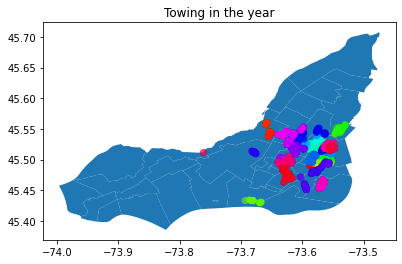

In [15]:
fig, ax = plt.subplots(1, figsize=(8, 4))
boroughs.plot(ax=ax)
parking_spots_geo.plot(ax=ax, marker='o', cmap = "hsv", alpha=0.075, label='centroids')
plt.title('Towing in the year')
# plt.savefig(os.path.join(RPT_FIGURES_DIR, output_filename))

In [16]:
parking_spots_geo['Cities'].unique()

array(['Ville-Marie', 'Ahuntsic-Cartierville', 'Lachine',
       'Mercier-Hochelaga-Maisonneuve', 'Le Plateau-Mont-Royal',
       'Rosemont-La Petite-Patrie', 'Saint-Laurent', 'Le Sud-Ouest',
       'Cote-des-Neiges-Notre-Dame-de-Grace', 'Outremont',
       'Villeray-Saint-Michel-Parc-Extension', 'Verdun'], dtype=object)

In [17]:
spots_cities = parking_spots_geo['Cities'].unique()
# ['Ville-Marie', 'Ahuntsic-Cartierville', 'Lachine',
#        'Mercier-Hochelaga-Maisonneuve', 'Le Plateau-Mont-Royal',
#        'Rosemont-La Petite-Patrie', 'Saint-Laurent', 'Le Sud-Ouest',
#        'Cote-des-Neiges-Notre-Dame-de-Grace', 'Outremont',
#        'Villeray-Saint-Michel-Parc-Extension', 'Verdun']

In [22]:
from sklearn.metrics import plot_confusion_matrix, classification_report
y_true = parking_spots_geo['Cities']
y_pred = parking_spots_geo['new_centroids']
cm = confusion_matrix(y_true, y_pred, labels=spots_cities)
print(classification_report(y_true, y_pred, target_names=spots_cities, zero_division=0))
# plt.matshow(cm)

                                      precision    recall  f1-score   support

                         Ville-Marie       0.00      0.00      0.00       338
               Ahuntsic-Cartierville       0.00      0.00      0.00      1435
                             Lachine       0.00      0.00      0.00       220
       Mercier-Hochelaga-Maisonneuve       0.20      0.32      0.25      3808
               Le Plateau-Mont-Royal       0.00      0.00      0.00       659
           Rosemont-La Petite-Patrie       0.08      1.00      0.15       518
                       Saint-Laurent       0.00      0.00      0.00       628
                        Le Sud-Ouest       0.00      0.00      0.00      1508
 Cote-des-Neiges-Notre-Dame-de-Grace       0.00      0.00      0.00       191
                           Outremont       0.00      0.00      0.00       884
Villeray-Saint-Michel-Parc-Extension       0.74      0.59      0.66      7673
                              Verdun       0.00      0.00      

In [ ]:
from sklearn.metrics import classification_report
y_true = parking_spots_geo['Cities']
y_pred = parking_spots_geo['new_centroids']